# Task 1.

The goals are:
1. Record IRC of some interesting place(the wild/in Kazan/Innopolis/somewhere else). Take
some pictures of the place where the IRC is recorded. This will be the kernel of your FIR filter.
Normalize the kernel so that the maximum value is 1.
2. Implement the convolution algorithm. Try to optimize its execution time. As a rule of thumb,
the implementation that is vectorized (no loops) will be the fastest. You may use python's
time.time() function to measure the execution time. Compare regular convolution
(implement it with striding, do not use built-in convolution) and FFT based (do not use built-in FFT convolve).
3. Apply the environment effect of your chosen place on your favorite track by convolving it
with IRC using your custom algorithm. Also convolve the following tracks with IRC:
voice.wav , violin.wav , speech.wav , and drums.wav . All files can be downloaded from
the document head.
4. Equivalence of Circular and Linear Convolution Theorem
5. Compare the complexities of regular and FFT convolution. Use the ratio of sequence length
to the kernel size as an additional parameter for investigation. When does it make
sense to use regular convolution and when it is better to use FFT convolution?

## 1.Record IRC of some interesting place(the wild/in Kazan/Innopolis/somewhere else). Take some pictures of the place where the IRC is recorded. This will be the kernel of your FIR filter. Normalize the kernel so that the maximum value is 1
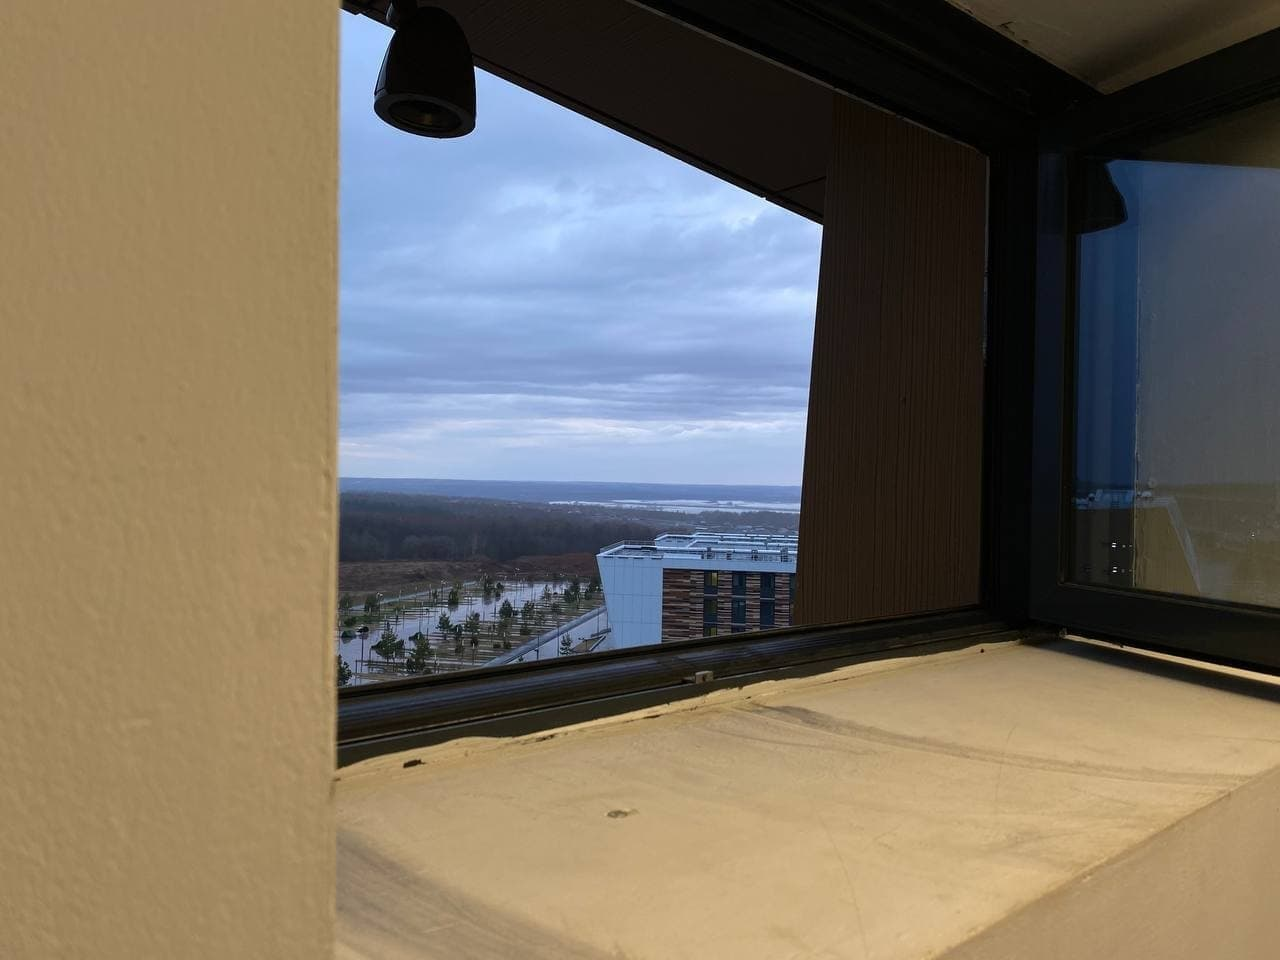

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio

# Clap
clap_rate, clap = wavfile.read('Clap16.wav')

# find general offset from zero amplitude which is the mean
general_offset = np.mean(clap)

# compensate amplitude offset by substracting it from the record
impulse_response = np.array(list(map(lambda x: x-general_offset, clap))) # subtract from each value

# calculate number of samples
samples = len(clap)

# create the plot
x = np.linspace(0, samples, samples) # x axes
y = impulse_response # y axes
plt.plot(x, y) # plot the graph
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Graph with compensated offset')
plt.show()

# generate audio
Audio(clap.T,rate=clap_rate)

## 2. Implement the convolution algorithm. Try to optimize its execution time.
* regular convolution (implement it with striding, do not use built-in convolution)
* no loops (vectorized approach)
* FFT based (do not use built-in FFT convolve)

In [ ]:
from numba import jit
from scipy.fftpack import fft,ifft


@jit(nopython=True) 
def regular_convolution(N, x_padded, h_padded):
  y = np.zeros(N)
  for n in range (N):
    for k in range (N):
      if n >= k:
        y[n] = y[n]+x_padded[n-k]*h_padded[k]
  return y

def vectorized_convolution(N, x, h):
  y = []
  if h.shape[0] < x.shape[0]:
    zeros = np.zeros(h.shape[0]-1)
    new_signal = np.concatenate((x,zeros), axis=0)
    new_signal = np.concatenate((zeros, new_signal), axis=0)
    for i in range(N):
      res = np.dot(new_signal[i:(i+h.shape[0])], h[::-1])
      y.append(res)
  else:
    zeros = np.zeros(x.shape[0]-1)
    new_signal = np.concatenate((h,zeros), axis=0)
    new_signal = np.concatenate((zeros, new_signal), axis=0)
    for i in range(N):
      res = np.dot(new_signal[i:(i+x.shape[0])], x[::-1])
      y.appends(res)
  return np.array(y)

def fft_convolution(N, x, h):
  return ifft(fft(x,N)*(fft(h,N))) 

In [ ]:
import time

# drums
h = impulse_response[:,0] #impulse response (clap) with the samples from the left audio channel
drums_rate, drums = wavfile.read('drums.wav')
x = drums #input response 
N = len(h)+len(x)-1

In [ ]:
# Convolution using regular approach with loops
m = N-len(x)
n = N-len(h)
#Padding zeros to x and h to make their length to N
x_padded =np.pad(x,(0,m),'constant')
h_padded =np.pad(h,(0,n),'constant')
start = time.time()
y = regular_convolution(N, x_padded, h_padded)
end = time.time()
print("Elapsed time = %s" % (end - start))
Audio(y,rate=drums_rate)

In [ ]:
# Convolution using no loops approach
start = time.time()
y = vectorized_convolution(N, x, h)
end = time.time()
print("Elapsed time = %s" % (end - start))
Audio(y,rate=drums_rate)

In [ ]:
# Convolution using FFT and IFFT
start = time.time()
y = fft_convolution(N, x, h)
end = time.time()
print("Elapsed time = %s" % (end - start))
Audio(y,rate=drums_rate)

## 3. Apply the environment effect of your chosen place on your favorite track by convolving it with IRC using your custom algorithm. 

In [ ]:
# Sherlock :)
sherlock_rate, sherlock = wavfile.read('Sherlock.wav')
x = sherlock[:,0]
N = len(h)+len(x)-1

y = fft_convolution(N, x, h)
Audio(y,rate=clap_rate)

Convolve the following tracks with IRC: voice.wav, violin.wav, speech.wav and drums.wav. 

In [ ]:
# voice
voice_rate, voice = wavfile.read('voice.wav')
x = voice #input response 
N = len(h)+len(x)-1

y = fft_convolution(N, x, h)
Audio(y,rate=clap_rate)

In [ ]:
# violin
violin_rate, violin = wavfile.read('violin.wav')
x = violin
N = len(h)+len(x)-1

y = fft_convolution(N, x, h)
Audio(y,rate=clap_rate)

In [ ]:
# speech
speech_rate, speech = wavfile.read('speech.wav')
x = speech[:,0]
N = len(h)+len(x)-1

y = fft_convolution(N, x, h)
Audio(y,rate=clap_rate)

In [ ]:
# drums
drums_rate, drums = wavfile.read('drums.wav')
x = drums
N = len(h)+len(x)-1

y = fft_convolution(N, x, h)
Audio(y,rate=clap_rate)

## 4. Prove Equivalence of Circular and Linear Convolution Theorem:

Prove that linear and circular convolutions between a length-N sequence $x$ and length-K sequence $h$ are equivalent when the period of the circular convolution $M$ satisfies $M \geq N + K - 1$

1) let $l$ be linear convolution and $c$ be circular convolution

2) Circular convolution formula: $(x*h)_n = \sum_{k=0}^{N-1}x_k \cdot h_{(n-k)mod N}$, where $n \in [0, N-1]$

3) We can divide this sum into two sums: $c_n = \sum_{k=0}^{n}x_k \cdot h_{(n-k)} + \sum_{k=n+1}^{N-1}x_k \cdot h_{(N+n-k)}$, where $n-k \geq 0$ and $n-k \leq 0$

4) Now in the first sum $b_{i-k} = 0$ when $k > n$ and in the second $b_{N+n-k} = 0$ when $k < n$, that is why we can rewrite this sum like this: $c_n = \sum_{k=0}^{N-1}x_k \cdot h_{(n-k)} + \sum_{k=0}^{N-1}x_k \cdot h_{(N+n-k)} = l_n + c_{N+k}$

5) Linear convolution can be computed as circular if the second sum is equal to zero. Such a condition will held if $M \geq N + K - 1$, where M is a period of the circular convolution.



## 5. Compare the complexities of regular and FFT convolution. Use the ratio of sequence length to the kernel size as an additional parameter for investigation. When does it make sense to use regular convolution and when it is better to use FFT convolution?

* regular approach with two loops - O($N^2$)
* fft based approach - O($Nlog(N)$)

The computational complexity for an n-element convolution on m points of data is O($n\cdot m$). 

The computational complexity for an 𝑛-element FFT is, indeed (𝑛log𝑛). But it coughs up 𝑛 points.

The savings in using the FFT to do convolution is that with your 𝑛-element filter you can do the FFT in chunks of 2𝑛 points each. Then you can use overlap-add (do a web search for the term) to reassembly the filter output which, outside of numerical scrud, will be the same thing you'd have gotten using convolution.

# Task 2.

1. Write down the equation for the canonical representation of the IIR filter.
2. Implement a function that creates an IIR filter. (Python is not very good with for loops. You
can use something like numba to speed up computations)
3. Create two filters: a lowpass filter - a filter that allows only slowly changing signals through,
and a highpass filter - the filter that allows only fast-changing signals through.
4. Apply these filters to a piece of music recording. After applying low pass filter you should
hear mostly the bass. After a highpass filter, you will mostly hear piano and cymbals (metal
plates).
5. Compute the approximate DFT spectrum of these IIR filters. Verify that filters work as
expected

1. Write down the equation for the canonical representation of the IIR filter.

$y_k = \frac{1}{a_0}(\sum_{m=0}^{M}b_m \cdot x_{k-m} - \sum_{n=1}^{N}a_n \cdot y_{k-n})$

2. Implement a function that creates an IIR filter.

3. Create two filters: a lowpass filter - a filter that allows only slowly changing signals through, and a highpass filter - the filter that allows only fast-changing signals through

In [ ]:
@jit(nopython=True)
def IIR_filter(x, a, b):  
  y = []
  K = len(x)
  N = len(a)
  M = len(b)
  for k in range(0, K):
    first_sum = 0
    for m in range(0, M):
      if (k-m < 0):
        first_sum += 0
      else:
        first_sum += b[m]*x[k-m]
    second_sum = 0
    for n in range(0, N):
      if (k-n-1 < 0):
        second_sum += 0
      else:
        second_sum += a[n]*y[k-n-1]
      res = (first_sum + second_sum)
    y.append(res)
  return y

4. Apply these filters to a piece of music recording. After applying low pass filter you should hear mostly the bass. After a highpass filter, you will mostly hear piano and cymbals (metal plates). You should get similar DFT spectrum of the music after processing

In [ ]:
music_rate, music = wavfile.read('music.wav')
Audio(music, rate=music_rate)

In [ ]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones
a_lowpass = np.array([1.9733442497812987,
     -0.9736948719763])# coefficients for a_1 and a_2
b_lowpass = np.array([0.00008765554875401547,
     0.00017531109750803094,
     0.00008765554875401547]) # coefficients for b_0, b_1 and b_2
     
lowpass_y = np.array(IIR_filter(music, a_lowpass, b_lowpass))
Audio(lowpass_y, rate=music_rate)

In [ ]:
# Highpass, starts passing frequencies after 3kHz
a_highpass = np.array([-0.3769782747249014,
     -0.19680764477614976]) # coefficients for a_1 and a_2
b_highpass = np.array([0.40495734254626874,
     -0.8099146850925375,
     0.4049573425462687]) # coefficients for b_0, b_1 and b_2

highpass_y = np.array(IIR_filter(music, a_highpass, b_highpass))
Audio(highpass_y, rate=music_rate)

You should get similar DFT spectrum of the music after processing

In [ ]:
# plot music signal and lowpassed signal in frequency domain

# for initial signal
fft_music = fft(music, len(music))

m = len(music)
n_music = np.arange(m//2)
music_period = (m//2)/music_rate # period
freq_music = n_music/music_period # frequency

fft_music = fft_music[:m//2]

# for lowpassed signal
fft_lowpass = fft(lowpass_y, len(lowpass_y))

m = len(fft_lowpass)
n_lowpass = np.arange(m//2)
T_lowpass = (m//2)/music_rate # period
freq_lowpass = n_lowpass/T_lowpass # frequency

fft_lowpass = fft_lowpass[:m//2]

# plot
plt.plot(freq_music, abs(fft_music))
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.plot(freq_lowpass, abs(fft_lowpass))
plt.show()

In [ ]:
# plot music signal and highpassed signal in frequency domain

# for initial signal
fft_music = fft(music, len(music))

m = len(music)
n_music = np.arange(m)
music_period = (m)/music_rate # period
freq_music = n_music/music_period # frequency

# for highpassed signal
fft_highpass = fft(highpass_y, len(highpass_y))

m = len(fft_highpass)
n_highpass = np.arange(m)
T_highpass = (m)/music_rate # period
freq_highpass = n_highpass/T_highpass # frequency

# plot
plt.plot(freq_music, abs(fft_music))
plt.yscale("log")
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.plot(freq_highpass, abs(fft_highpass))
plt.show()

5. Compute the approximate DFT spectrum of these IIR filters. Verify that filters work as expected

In [ ]:
dirac = [1,0,0,0,0,0,0,0,0,0,0,0,0]

In [ ]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones
a_lowpass = np.array([1.9733442497812987,
     -0.9736948719763])# coefficients for a_1 and a_2
b_lowpass = np.array([0.00008765554875401547,
     0.00017531109750803094,
     0.00008765554875401547]) # coefficients for b_0, b_1 and b_2
     
lowpass_dirac = np.array(IIR_filter(dirac, a_lowpass, b_lowpass))

In [ ]:
# for lowpassed signal
fft_lowpass_dirac = fft(lowpass_dirac, len(lowpass_dirac))

m = len(fft_lowpass_dirac)
n_lowpass_dirac = np.arange(m)
T_lowpass_dirac = (m)/5 # period
freq_lowpass_dirac = n_lowpass_dirac/T_lowpass_dirac # frequency

# fft_lowpass_dirac = fft_lowpass_dirac[:m//2]

# plot
plt.stem(freq_lowpass_dirac, abs(fft_lowpass_dirac), 'b', \
         markerfmt=" ", basefmt="-b")
plt.title('Freq (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
# Highpass, starts passing frequencies after 3kHz
a_highpass = np.array([-0.3769782747249014,
     -0.19680764477614976]) # coefficients for a_1 and a_2
b_highpass = np.array([0.40495734254626874,
     -0.8099146850925375,
     0.4049573425462687]) # coefficients for b_0, b_1 and b_2

highpass_dirac = np.array(IIR_filter(dirac, a_highpass, b_highpass))

In [ ]:
# for lowpassed signal
fft_highpass_dirac = fft(highpass_dirac, len(highpass_dirac))

m_highpass_dirac = len(fft_highpass_dirac)
n_highpass_dirac = np.arange(m_highpass_dirac)
T_highpass_dirac = (m_highpass_dirac)/5 # period
freq_highpass_dirac = n_highpass_dirac/T_highpass_dirac # frequency

# fft_lowpass_dirac = fft_lowpass_dirac[:m//2]

# plot
plt.stem(freq_highpass_dirac, abs(fft_highpass_dirac), 'b', \
         markerfmt=" ", basefmt="-b")
plt.title('Freq (Hz)')
plt.ylabel('Magnitude')
plt.show()

1) IRC - The response of a filter (linear system) to the Dirac input is called Impulse Response Characteristic, or IRC for short

2) Why the Dirac's Delta sequence is used in recording IRC? 

3) What is an FIR filter? - Finite response filter (convolution)

4) What is an IIR filter and how it differs from an FIR filter? - Infinite response filter - kernel of infinite length
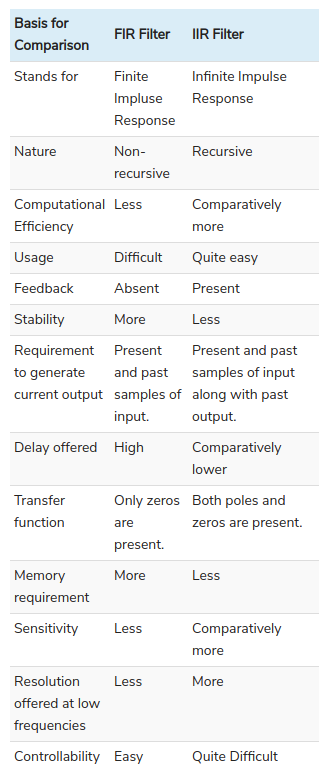

5) Define convolution? In what way the convolution operation similar to the cross-correlation operation?

Convolution: $(x*h)_n = \sum_{k=0}^{n-1}x_k \cdot h_{n-k}$

Cross-corelation: $c_n = \sum_{k=-\infty}^{k = \infty}x_k \cdot y*_{k-n}$

For real numbers and finite vectors they are the same

6) Assume you have a system L. You want to simulate the response of a system to the input signal S. How can you do this? What will be the response of this system to the input signal $S_1 + S_2$?

Apply L to s. $LS_1 + LS_2$